In [2]:
import json
import torch
import torchvision
from torch import nn
from diffusers import UNet2DModel, DDPMScheduler


import safetensors
from huggingface_hub import hf_hub_download
from huggingface_hub import HfApi, create_repo, get_full_repo_name, ModelCard
from huggingface_hub import notebook_login

from matplotlib import pyplot as plt
from tqdm.auto import tqdm


device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')
# Número de GPUs disponibles
print(torch.cuda.device_count())

# Nombre de cada GPU
for i in range(torch.cuda.device_count()):
    print(torch.cuda.get_device_name(i))


Using device: cuda
1
NVIDIA A10


## Define CustomModel class
```python

In [2]:


class ClassConditionedUnet(nn.Module):
  def __init__(self, num_classes=10, class_emb_size=10):
    super().__init__()

    # The embedding layer will map the class label to a vector of size class_emb_size
    self.class_emb = nn.Embedding(num_classes, class_emb_size)

    # Self.model is an unconditional UNet with extra input channels
    # to accept the conditioning information (the class embedding)
    self.model = UNet2DModel(
        sample_size=28,           # output image resolution. Equal to input resolution
        in_channels=1 + class_emb_size, # Additional input channels for class cond
        out_channels=1,           # the number of output channels. Equal to input
        layers_per_block=3,       # three residual connections (ResNet) per block
        block_out_channels=(128, 256, 512), # N of output channels for each block. Inverse for upsampling
        down_block_types=(
            "DownBlock2D",  # a regular ResNet downsampling block
            "AttnDownBlock2D",
            "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        ),
        up_block_types=(
            "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
            "AttnUpBlock2D",
            "UpBlock2D",  # a regular ResNet upsampling block
        ),
        dropout = 0.1,  # Dropout prob between Conv1 and Conv2 in a block. From Improved DDPM paper
    )

  # Forward method takes the class labels as an additional argument
  def forward(self, x, t, class_labels):
    bs, ch, w, h = x.shape # x is shape (bs, 1, 28, 28)

    # class conditioning embedding to add as additional input channels
    class_cond = self.class_emb(class_labels) # Map to embedding dimension
    class_cond = class_cond.view(bs, class_cond.shape[1], 1, 1).expand(bs, class_cond.shape[1], w, h)
    # class_cond final shape (bs, 4, 28, 28)

    # Model input is now x and class cond concatenated together along dimension 1
    # We need provide additional information (the class label)
    # to every spatial location (pixel) in the image. Not changing the original
    # pixels of the images, but adding new channels.
    net_input = torch.cat((x, class_cond), 1) # (bs, 5, 28, 28)

    # Feed this to the UNet alongside the timestep and return the prediction
    # with image output size
    return self.model(net_input, t).sample # (bs, 1, 28, 28)
  


## Safe Model to Safetensors

In [ ]:
# Load the model
model_save_path = "/home/ahuertas/work/Miscelanea/GenAI-FashionMNIST/notebooks/fashion_class_cond_unet_model_best/fashion_class_cond_unet_model_best.pth"
cond_unet_model_loaded = torch.load(model_save_path)

In [4]:
# Define the path to save the SafeTensors file
safetensors_model_path = "/home/ahuertas/work/Miscelanea/GenAI-FashionMNIST/notebooks/fashion_class_cond_unet_model_best/fashion_class_cond_unet_model_best.safetensors"

# Save the model state dictionary as SafeTensors
state_dict = cond_unet_model_loaded.state_dict()
safetensors.torch.save_file(state_dict, safetensors_model_path)

## Create Repo and Push to Huggingface Hub

In [12]:
# Authenticate with Huggingface Hub
notebook_login()

# Define the model name
model_name = "conditioned-unet-fashion-mnist-non-ema"
hub_model_id = get_full_repo_name(model_name)
create_repo(hub_model_id)
api = HfApi()

In [12]:
content = f"""
---
license: mit
tags:
- pytorch
- diffusers
- class-conditional-image-generation
- diffusion-models-class
---

# Overview

This model is a diffusion model for conditional image generation of  clothes from the FashionMNIST dataset. The model is a class-conditioned UNet that generates images of clothes conditioned on the class label.
The code for this model can be found in this [GitHub repository](https://github.com/Huertas97/GenAI-FashionMNIST)

## Usage

As it is a Custom Class Model of the Diffusers library, it can be used as follows:

Setup
```python	
import json
import torch
import torchvision
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from torch import nn
from diffusers import UNet2DModel, DDPMScheduler
import safetensors
from huggingface_hub import hf_hub_download
device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
```
Load the ClassConditionedUnet model safetensor:
```python
# Custom Class
class ClassConditionedUnet(nn.Module):
  def __init__(self, num_classes=10, class_emb_size=10):
    super().__init__()

    # The embedding layer will map the class label to a vector of size class_emb_size
    self.class_emb = nn.Embedding(num_classes, class_emb_size)

    # Self.model is an unconditional UNet with extra input channels
    # to accept the conditioning information (the class embedding)
    self.model = UNet2DModel(
        sample_size=28,           # output image resolution. Equal to input resolution
        in_channels=1 + class_emb_size, # Additional input channels for class cond
        out_channels=1,           # the number of output channels. Equal to input
        layers_per_block=3,       # three residual connections (ResNet) per block
        block_out_channels=(128, 256, 512), # N of output channels for each block. Inverse for upsampling
        down_block_types=(
            "DownBlock2D",  # a regular ResNet downsampling block
            "AttnDownBlock2D",
            "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        ),
        up_block_types=(
            "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
            "AttnUpBlock2D",
            "UpBlock2D",  # a regular ResNet upsampling block
        ),
        dropout = 0.1,  # Dropout prob between Conv1 and Conv2 in a block. From Improved DDPM paper
    )

  # Forward method takes the class labels as an additional argument
  def forward(self, x, t, class_labels):
    bs, ch, w, h = x.shape # x is shape (bs, 1, 28, 28)

    # class conditioning embedding to add as additional input channels
    class_cond = self.class_emb(class_labels) # Map to embedding dimension
    class_cond = class_cond.view(bs, class_cond.shape[1], 1, 1).expand(bs, class_cond.shape[1], w, h)
    # class_cond final shape (bs, 4, 28, 28)

    # Model input is now x and class cond concatenated together along dimension 1
    # We need provide additional information (the class label)
    # to every spatial location (pixel) in the image. Not changing the original
    # pixels of the images, but adding new channels.
    net_input = torch.cat((x, class_cond), 1) # (bs, 5, 28, 28)

    # Feed this to the UNet alongside the timestep and return the prediction
    # with image output size
    return self.model(net_input, t).sample # (bs, 1, 28, 28)

# Define paths to download the model and scheduler
repo_name = "Huertas97/conditioned-unet-fashion-mnist-non-ema"

# Download the safetensors model file
model_file_path = hf_hub_download(repo_id=repo_name, filename="fashion_class_cond_unet_model_best.safetensors")

# # Load the Class Conditioned UNet model state dictionary
state_dict = safetensors.torch.load_file(model_file_path)
model_classcond_native =  ClassConditionedUnet()
model_classcond_native.load_state_dict(state_dict).to(device)
```

Load the DDPMScheduler:
```python
# Download and load the scheduler configuration file
scheduler_file_path = hf_hub_download(repo_id=repo_name, filename="scheduler_config.json")

with open(scheduler_file_path, 'r') as f:
    scheduler_config = json.load(f)

noise_scheduler = DDPMScheduler.from_config(scheduler_config)
```


Use the model to generate images:

```python
desired_class = [7] # desired class from 0 -> 9
num_samples = 2  # num of images to generate per class

# Prepare random x to start from
x = torch.randn(num_samples*len(desired_class), 1, 28, 28).to(device)

# Prepare the desired classes
y = torch.tensor([[i]*num_samples for i in desired_class]).flatten().to(device)

model_classcond_native = model_classcond_native.to(device)

# Sampling loop
for i, t in tqdm(enumerate(noise_scheduler.timesteps)):
  # Get model pred
  with torch.no_grad():
      residual = model_classcond_native(x, t, y)

  # Update sample with step
  x = noise_scheduler.step(residual, t, x).prev_sample

# Show the results
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu().clip(-1, 1), nrow=8)[0], cmap='Greys')
```
"""

hub_model_id = "Huertas97/conditioned-unet-fashion-mnist-non-ema"
# Model card
card = ModelCard(content)
card.push_to_hub(hub_model_id)

# # Push safetensor model
# api.upload_file(
#     path_or_fileobj=safetensors_model_path,
#     path_in_repo="fashion_class_cond_unet_model_best.safetensors",
#     repo_id=hub_model_id,
#     repo_type="model",
# )

# # Push scheduler config
# scheduler_save_path = "/home/ahuertas/work/Miscelanea/GenAI-FashionMNIST/notebooks/fashion_class_cond_unet_model_best/scheduler/scheduler_config.json"
# api.upload_file(
#     path_or_fileobj=scheduler_save_path,
#     path_in_repo="scheduler_config.json",
#     repo_id=hub_model_id,
#     repo_type="model",
# )

CommitInfo(commit_url='https://huggingface.co/Huertas97/conditioned-unet-fashion-mnist-non-ema/commit/882419041559b7218a8ea5bb7cc108f731cc481f', commit_message='Upload README.md with huggingface_hub', commit_description='', oid='882419041559b7218a8ea5bb7cc108f731cc481f', pr_url=None, pr_revision=None, pr_num=None)

## Load from the huggingFace Hub

In [3]:
# Define paths to download the model and scheduler
repo_name = "Huertas97/conditioned-unet-fashion-mnist-non-ema"

# Download the safetensors model file
model_file_path = hf_hub_download(repo_id=repo_name, filename="fashion_class_cond_unet_model_best.safetensors")

# # Load the Class Conditioned UNet model state dictionary
state_dict = safetensors.torch.load_file(model_file_path)
model_classcond_native =  ClassConditionedUnet()
model_classcond_native.load_state_dict(state_dict)

# Download and load the scheduler configuration file
scheduler_file_path = hf_hub_download(repo_id=repo_name, filename="scheduler_config.json")

with open(scheduler_file_path, 'r') as f:
    scheduler_config = json.load(f)

noise_scheduler = DDPMScheduler.from_config(scheduler_config)


#### Test the loaded model

0it [00:00, ?it/s]

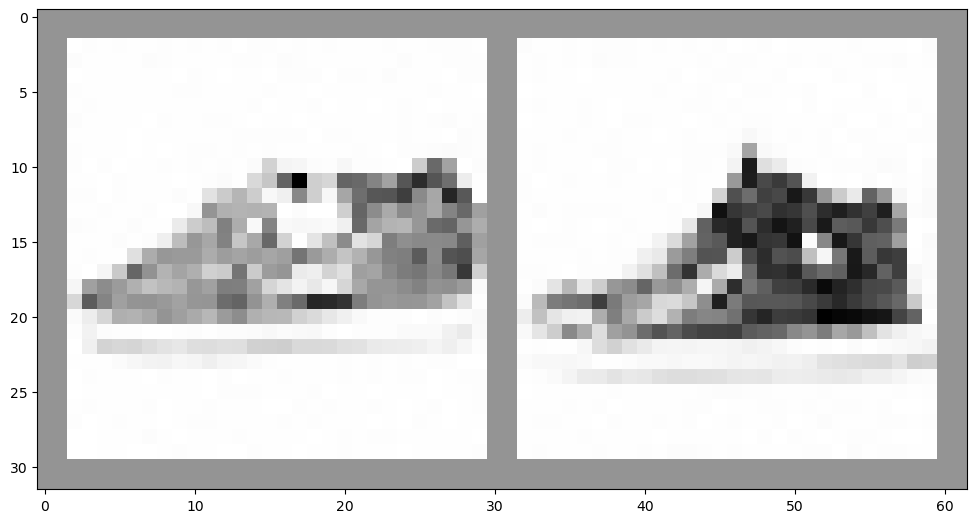

In [12]:
desired_class = [7] # desired class from 0 -> 9
num_samples = 2  # num of images to generate per class

# Prepare random x to start from
x = torch.randn(num_samples*len(desired_class), 1, 28, 28).to(device)

# Prepare the desired classes
y = torch.tensor([[i]*num_samples for i in desired_class]).flatten().to(device)

model_classcond_native = model_classcond_native.to(device)

# Sampling loop
for i, t in tqdm(enumerate(noise_scheduler.timesteps)):
  # Get model pred
  with torch.no_grad():
      residual = model_classcond_native(x, t, y)

  # Update sample with step
  x = noise_scheduler.step(residual, t, x).prev_sample

# Show the results
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu().clip(-1, 1), nrow=8)[0], cmap='Greys')